# NetFlix Rating Prediction

For more information about the project structure and description see the github repository <b><a href="https://github.com/diegopmayer/netflix_rating_prediction">click here</a>

## 1.0 - Importing

### 1.1 - Libraries

In [261]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import requests
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display  import HTML
from IPython.display       import Image

# transformation
from sklearn.preprocessing import RobustScaler, PowerTransformer
from fast_ml.model_development import  train_valid_test_split

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import Lasso, LinearRegression
from sklearn import neighbors
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import svm
from catboost import CatBoostRegressor

# metrics
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error

### 1.2 - Helper Functions

In [406]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [18,9]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container{width:90% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()  

def cramer_v(x, y):

    # cm is Confusion Matrix
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    return np.sqrt((chi2/n) / min(k-1, r-1))


def data_cleaning(data):

	# delete and replace all nullable values
	data = data[data['rating'].notnull()]
	data = data.dropna(how='all') # delet the line if all line null
	data['date_added'] = data['date_added'].fillna('1970-01-01')
	data['release_year'] = data['release_year'].fillna(0)
	data['rating'] = data['rating'].fillna(0)
	data['duration'].fillna(0)
	data = data.fillna('')
	
	
	# string cleaning
	# removing the string and left only minutes
	data["duration"] =  [int(
		x.split()[0]) for x in data['duration'].fillna('0')]
	# replacing the tv show mean for mean of statinvestor data
	ind_tv = data['duration'][data['type'] == 'TV Show'].index
	data.loc[ind_tv, 'duration'] = 45
	
	
	# change dtype for simply, less memory and better performance
	data['date_added'] = pd.to_datetime(data['date_added'])
	data['release_year'] = data['release_year'].astype('int32')
	data['rating'] = data['rating'].astype('int32')
	df_cleaned = data
	
	return df_cleaned

	
def feature_eng(data):
	data['type'] = data['type'].map({'Movie':0, 'TV Show':1})
	data['year_added'] = data['date_added'].dt.year
	data['month_added'] = data['date_added'].dt.month
	data['day_added'] = data['date_added'].dt.day


	# title
	# split with ':'  and put in other column
	#data['title_a'] = data['title'].apply(lambda x: x.split(':')[0])

	# director
	# split names with coma ','
	#data['director_a'] = data['director'].apply(lambda x: x.split(',')[0])

	# cast
	# split names with coma ',' getting the first cast
	#data['cast_a'] = data['cast'].apply(lambda x: x.split(',')[0])

	# listed in
	# split names with coma ',' getting the first listed in
	#data['listed_in_a'] = data['listed_in'].apply(lambda x: x.split(',')[0])


		# drop columns
	data = data.drop([
		'show_id',
		'title', 
		'director', 
		'cast', 
		'listed_in', 
		'description'
	], axis=1)
	
	# filter values
	data = data[data['rating'] > 0]
	df_eng = data.drop(['date_added'], axis=1)

	return df_eng



def data_transformation(data):
	
	# tranforming title_a in one hot encode
	#title_dum = pd.get_dummies(data['cast_a'], prefix='cast')
	#df_dum = pd.DataFrame()
	#for col in title_dum:
	#	if title_dum[col].sum() >=3:
	#		df_dum[col] = title_dum[col]
	#data = pd.concat([data, df_dum], axis=1)
	#data = data.drop(['cast_a'], axis=1)

	# duration (poisson)
	pt = PowerTransformer(method='box-cox')
	pt.fit(data[['duration']]).lambdas_
	data['duration'] = pt.transform(data[['duration']])

	# country
	df_dum = pd.get_dummies(data['country'])
	df_dum_red = pd.DataFrame()
	for col in df_dum:
		if df_dum[col].sum() > 5:
			df_dum_red[col] = df_dum[col]
	data = pd.concat([data, df_dum_red], axis=1)
	data = data.drop(['country'], axis=1)

	# renaming columns
	col_list = list()
	for col in data.columns.to_list():
		col_list.append(col.replace(' ', '_').replace(',', ''))
	data.columns = col_list

	df_transf = data

	return df_transf

### 1.3 - Extracting Data

In [272]:
data = pd.read_excel("../dataset/bronze/dataset_netflix.xlsx")

### 1.4 - Splitting Data

In [273]:

#  Let' split the train and test because of data leakage
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(
    data, target='rating', train_size=0.8, valid_size=0.1, test_size=0.1
)

# shape check
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((4987, 11), (4987,), (623, 11), (623,), (624, 11), (624,))

### 1.5 - Save to silver layer

In [274]:
# Concatenating the x and y train and valid
df_train = pd.concat([x_train, y_train], axis=1)
df_valid = pd.concat([x_valid, y_valid], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)

# saving data to silver layer with parquet format
df_train.to_parquet("../dataset/silver/netflix_train.parquet")
df_valid.to_parquet("../dataset/silver/netflix_valid.parquet")
df_test.to_parquet("../dataset/silver/netflix_test.parquet")

## 2.0 - Data Cleaning

### 2.2 - Descriptive Statistical

In [275]:
# Numerical describe
num_data = (
    data.select_dtypes(
    include=['int64', 'int32', 'float64', 'float32']))
num_describe = (pd.concat([
    num_data.describe().T,
    pd.Series(num_data.kurtosis(), name='kurtosis'),
    pd.Series(num_data.skew(), name='skew')
    ], axis=1).round())
num_describe

# The Frequency is a peak and a little negative skew.

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
show_id,6234.0,76703679.0,10942965.0,247747.0,80035802.0,80163367.0,80244889.0,81235729.0,30.0,-5.0
release_year,6233.0,2013.0,9.0,1925.0,2013.0,2016.0,2018.0,2020.0,18.0,-4.0
rating,6233.0,64.0,19.0,0.0,59.0,68.0,76.0,97.0,4.0,-2.0


In [276]:
# Categorical
data.select_dtypes(
include=['object', 'string']).describe().T
# The top more watched was movie from the United States "before cleaning"

,count,unique,top,freq
type,6234,2,Movie,4265
title,6234,6172,The Silence,3
director,4264,3300,"Raúl Campos, Jan Suter",18
cast,6233,5470,bam,569
country,6233,555,United States,2031
duration,6233,201,1 Season,1321
listed_in,6233,461,Documentaries,299
description,6233,6225,A surly septuagenarian gets another chance at ...,3


In [277]:
# Date describe
data.describe(include=['datetime'], datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max
date_added,6222,2018-07-01 17:22:37.377049088,2008-01-01,2017-10-01,2018-09-30,2019-06-08,2020-01-18


### 2.4 - Data Types and Nullable values

In [278]:
pd.concat([
    pd.Series(data.dtypes, name='dtypes'), 
    pd.Series(data.isna().sum(), name='null_values'), 
    data.head(3).T], 
    axis=1)
    # The target has one null value, this case I'll delete them and replace the others nullable values

,dtypes,null_values,0,1,2
show_id,int64,0,81145628,80117401,70234439
type,object,0,Movie,Movie,TV Show
title,object,0,Norm of the North: King Sized Adventure,Jandino: Whatever it Takes,Transformers Prime
director,object,1970,"Richard Finn, Tim Maltby",NaN,NaN
cast,object,1,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...",Jandino Asporaat,"Peter Cullen, Sumalee Montano, Frank Welker, J..."
country,object,1,"United States, India, South Korea, China",United Kingdom,United States
date_added,datetime64[ns],12,2019-09-09 00:00:00,2016-09-09 00:00:00,2018-09-08 00:00:00
release_year,float64,1,2019.0,2016.0,2013.0
rating,float64,1,41.0,52.0,82.0
duration,object,1,90 min,94 min,1 Season


In [279]:
# Variables changes
def var_changes(data):
        
    # delete and replace all nullable values
    data = data[data['rating'].notnull()]
    data = data.dropna(how='all') # delet the line if all line null
    data['date_added'] = data['date_added'].fillna('1970-01-01')
    data['release_year'] = data['release_year'].fillna(0)
    data['rating'] = data['rating'].fillna(0)
    data = data.fillna('')

    # change dtype for simply, less memory and better performance
    data['date_added'] = pd.to_datetime(data['date_added'])
    data['release_year'] = data['release_year'].astype('int32')
    data['rating'] = data['rating'].astype('int32')

    # deleting
    data = data.drop('show_id', axis=1)
    return data

data = var_changes(data)

In [280]:
pd.concat([
    pd.Series(data.dtypes, name='dtypes'), 
    pd.Series(data.isna().sum(), name='null_values'), 
    data.head(3).T], 
    axis=1)
# all data null changed

,dtypes,null_values,0,1,2
type,object,0,Movie,Movie,TV Show
title,object,0,Norm of the North: King Sized Adventure,Jandino: Whatever it Takes,Transformers Prime
director,object,0,"Richard Finn, Tim Maltby",,
cast,object,0,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...",Jandino Asporaat,"Peter Cullen, Sumalee Montano, Frank Welker, J..."
country,object,0,"United States, India, South Korea, China",United Kingdom,United States
date_added,datetime64[ns],0,2019-09-09 00:00:00,2016-09-09 00:00:00,2018-09-08 00:00:00
release_year,int32,0,2019,2016,2013
rating,int32,0,41,52,82
duration,object,0,90 min,94 min,1 Season
listed_in,object,0,"Children & Family Movies, Comedies",Stand-Up Comedy,Kids' TV


### 2.5 - Saving data to silver layer

In [281]:
# saving the data cleaned on silver layer
data.to_parquet("../dataset/silver/netflix_data.parquet")

## 4.0 - Exploratory Data Analysis

> The future engineering will be create with EDA will be doing

In [354]:
# extracting data from silver layer
data = pd.read_parquet("../dataset/silver/netflix_data.parquet")

In [284]:
report = ProfileReport(data, title="Netflix reports", dark_mode=True)
report.to_file('netflix_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 258.57it/s]


### 4.0 - Hypothesis 

> List the possible hypothesis or business statements

* The top movies are from The united states
* The top Tv Series are from The united states
* The top movies are about heroes
* The top movies are stories from books
* How more recently movie and from the United States it's better
* How more awards better the rating

> Will be answer on the next cycle

#### 4.1 Target

<AxesSubplot:xlabel='rating', ylabel='Count'>

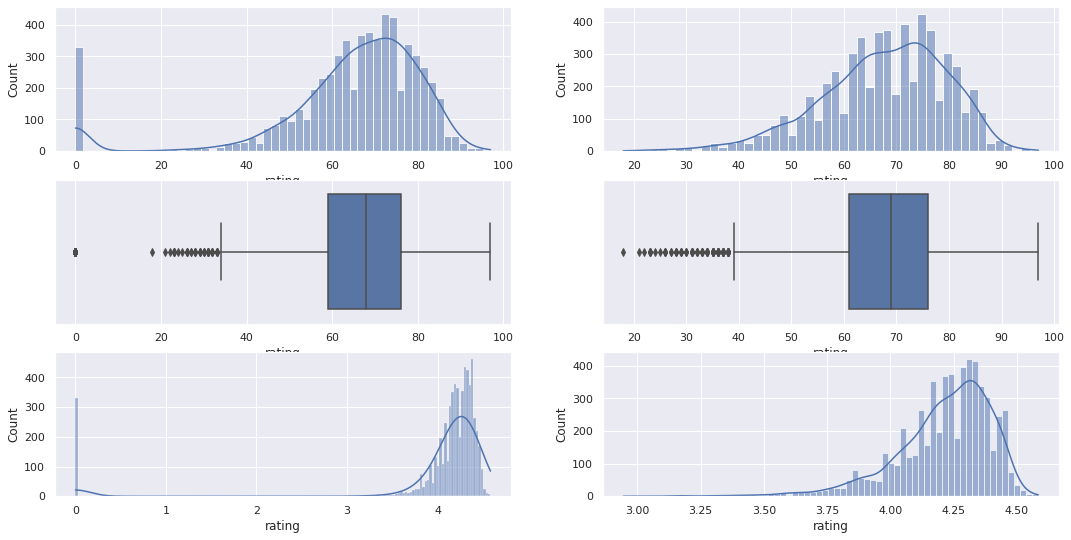

In [355]:
grid = plt.GridSpec(3,2)

# target distribution
plt.subplot(grid[0,0])
sns.histplot(data['rating'], kde=True);

# Target without zero values
plt.subplot(grid[0,1])
sns.histplot(data['rating'][data['rating'] > 0], kde=True);

# Boxplot to see the outliers
plt.subplot(grid[1,0])
sns.boxplot(x=data['rating']);

# Boxplot to see the outliers
plt.subplot(grid[1,1])
sns.boxplot(x=data['rating'][data['rating'] > 0]);

# Analysing normalization
plt.subplot(grid[2,0])
sns.histplot(np.log1p(data['rating']), kde=True)

# Analysing normalization
plt.subplot(grid[2,1])
sns.histplot(np.log1p(data['rating'][data['rating'] > 0]), kde=True)

# Let's left the original, we'll just filter where > 0

In [356]:
# filtering the data only upper of zero
data = data[data['rating'] > 0]

#### 4.2 Numeric

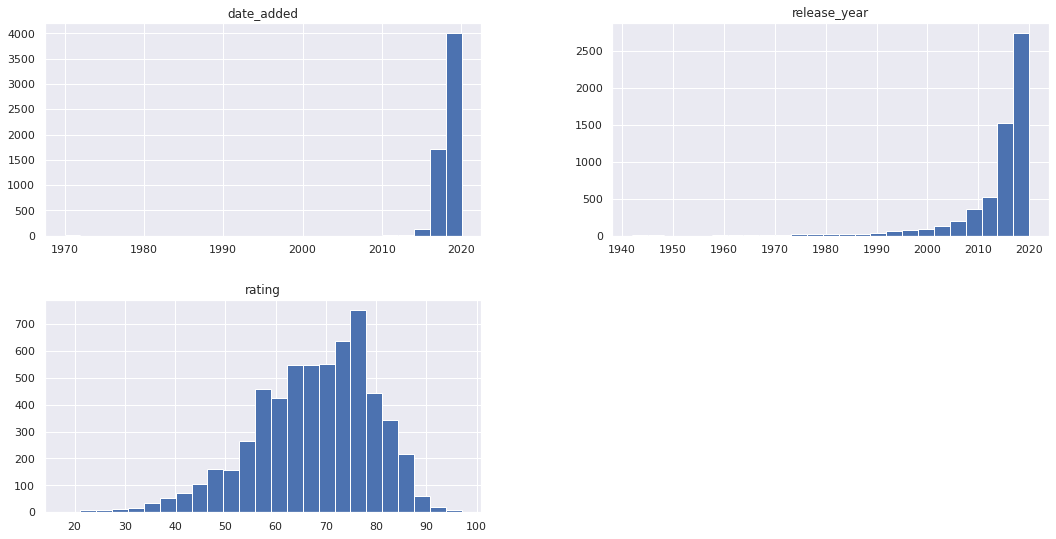

In [301]:
data.select_dtypes(exclude=['object']).hist(bins=25);
# Let's drop col -> show_id

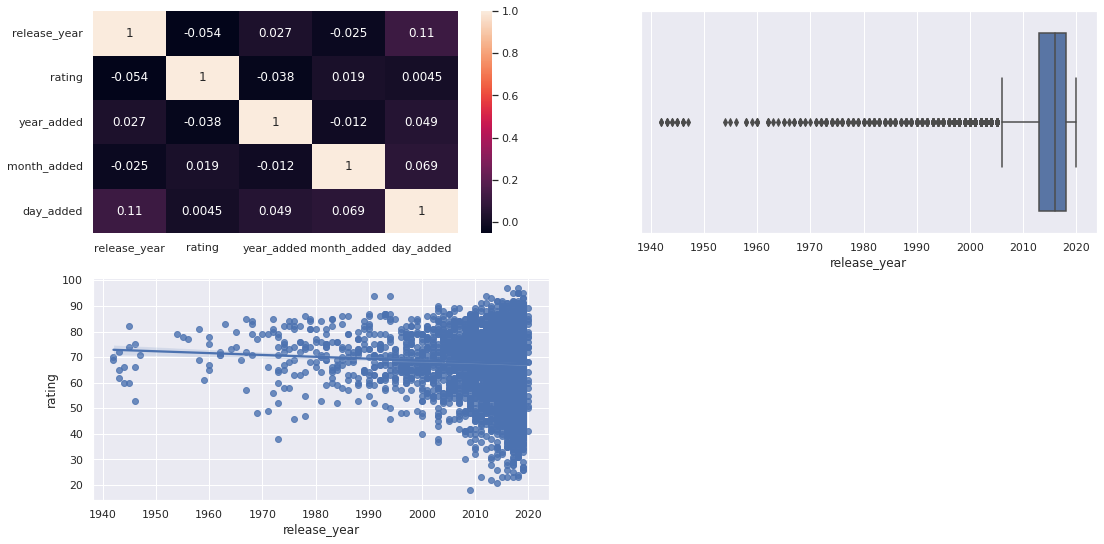

In [ ]:
# Slicing and filter for just numbers and date data types
num_attributes = data.select_dtypes(exclude='object')

grid = plt.GridSpec(2,2)

# Plotting heatmap
plt.subplot(grid[0,0])
sns.heatmap(num_attributes.corr(method='pearson'), annot=True);

plt.subplot(grid[0,1])
sns.boxplot(x=data['release_year']); 

plt.subplot(grid[1,0])
sns.regplot(data=data, x='release_year', y="rating");

# There are a consistently grouwing in a number of rating along years
# release_year there aren't a correlation with ratingj

In [358]:
data['year_added'] = data['date_added'].dt.year
data['month_added'] = data['date_added'].dt.month
data['day_added'] = data['date_added'].dt.day

# drop old column
data = data.drop(['date_added'], axis=1)

### 4.3 - Category

In [303]:
# Slicing and filter for just objects data types
cat_attributes = data.select_dtypes(include='object')

# For to get name of coluns and calculate cramer_v function 
list_cat = {}
rown = []
for col in cat_attributes.columns:
    for row in cat_attributes.columns:
        rown.append(cramer_v(cat_attributes[col], cat_attributes[row]))
        
    list_cat[col] = rown
    rown = []
    
# take the output from loop and convert to DataFrame
df_cat = pd.DataFrame(list_cat)
df_cat = df_cat.set_index(df_cat.columns)

Text(0.5, 1.0, 'Correlation of all categories variable')

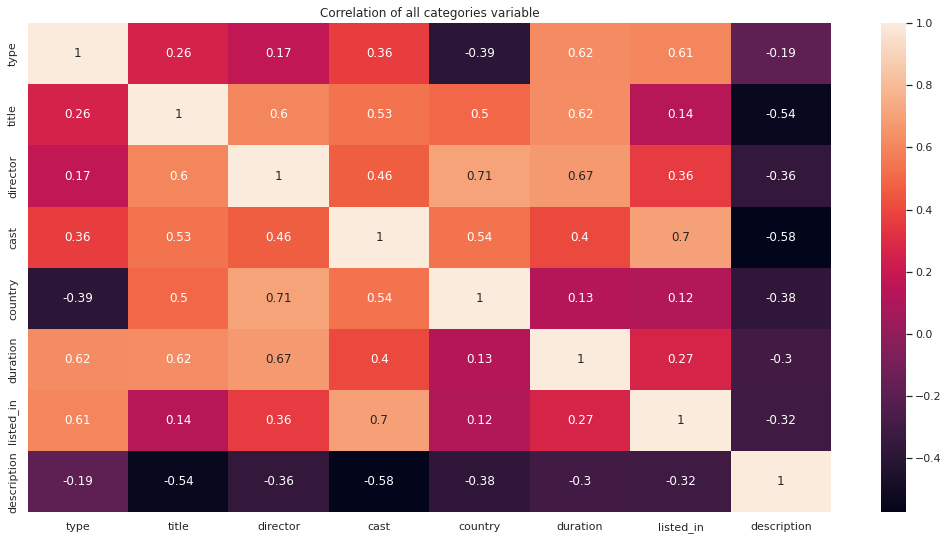

In [304]:
# plotting heatmap to cross correlation
sns.heatmap(df_cat.corr(method='pearson'), annot=True, );
plt.title("Correlation of all categories variable")

# there aren't a strong correlation, but might be not need remove anyone
# Obs, Pearson it's not correct method for categories, just to first view

#### column type

Movie      4085
TV Show    1818
Name: type, dtype: int64


Text(0.5, 1.0, 'Correlation for rating and type')

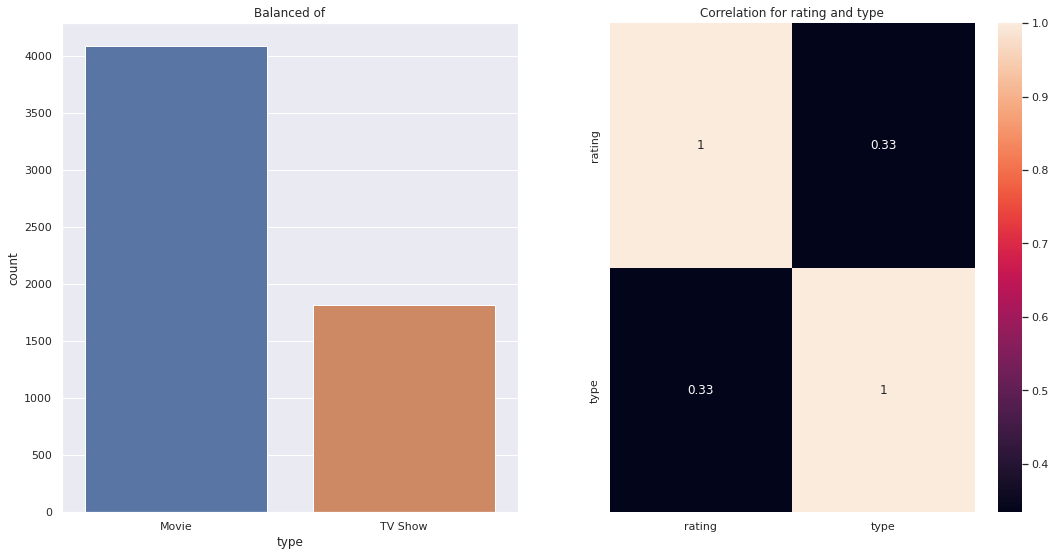

In [305]:
print(data['type'].value_counts())
# type - transform to numeric
type_num = data['type'].map({'Movie':0, 'TV Show':1})

grid = plt.GridSpec(1,2)

plt.subplot(grid[0,0])
sns.countplot(x=data['type']);
plt.title("Balanced of")

plt.subplot(grid[0,1])
sns.heatmap(
    pd.concat([data['rating'], type_num], axis=1)
    .corr(method='pearson'), annot=True);
plt.title("Correlation for rating and type")

In [359]:
# engoding the type
data['type'] = data['type'].map({'Movie':0, 'TV Show':1})

#### duration

In [307]:
data['duration'].value_counts().head(3)

1 Season     1190
2 Seasons     291
3 Seasons     155
Name: duration, dtype: int64

The statinvestor show that meaning of each episodes for many kind of tv shows

https://statinvestor.com/data/21444/episode-length-of-selected-tv-shows/


In [360]:
# getiing only number of seasons and min per movie
data["duration"] =  [int(
    x.split()[0]) for x in data['duration'].fillna('0')]

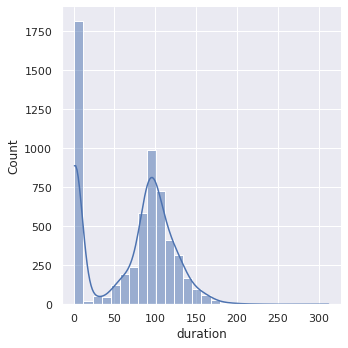

In [309]:
sns.displot(x=data['duration'], kde=True);
# as you see, the is a rightest kurtosis, let's down that

In [310]:
# extractin data from statinvestor for getting the mean of episodes
url = 'http://statinvestor.com/data/21444/episode-length-of-selected-tv-shows/'
response = requests.get(url=url)

# extracting table from html
tv_shows = pd.read_html(response.text)[0].rename(
    columns={0:'tv_shows_name', 1:'mean_time'
})
tv_shows.head(3)

,tv_shows_name,mean_time
0,Sherlock,88.3
1,Westworld,61.7
2,Preacher,60.3


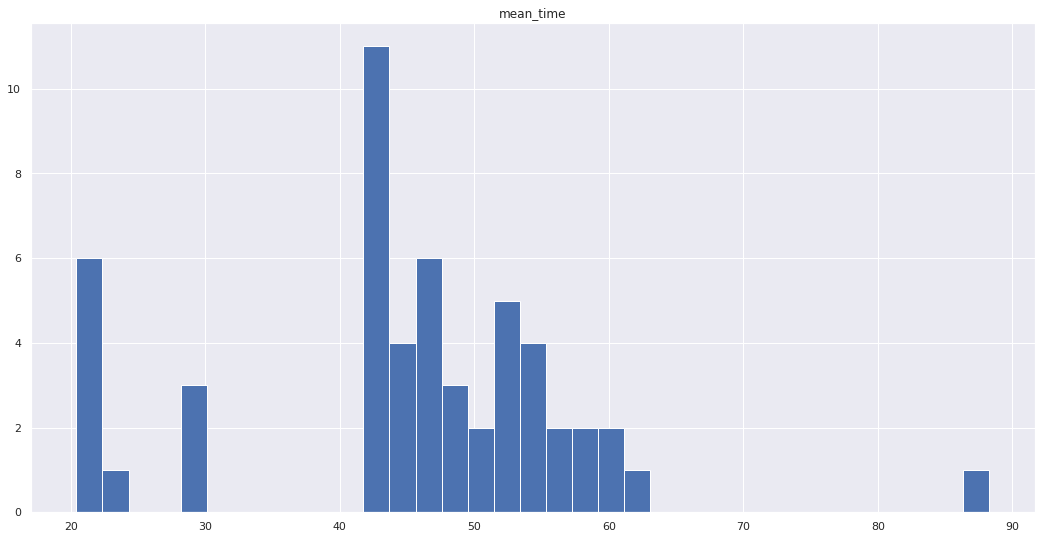

In [311]:
tv_shows.hist(bins=35);
# it's a poisson distribution

In [312]:
tv_shows['mean_time'].mean()

45.018867924528294

In [361]:
# for while let's get the mean of all tv shows
ind_tv = data['duration'][data['type'] == 1].index
data.loc[ind_tv, 'duration'] = tv_shows['mean_time'].mean().round()

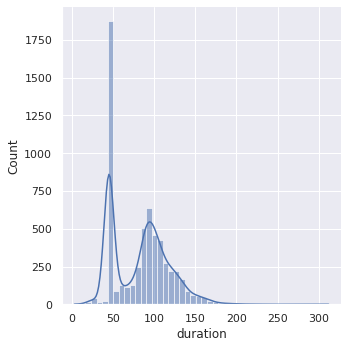

In [314]:
sns.displot(x=data['duration'], kde=True);

In [362]:
pt = PowerTransformer(method='box-cox')
pt.fit(data[['duration']]).lambdas_
data['duration'] = pt.transform(data[['duration']])

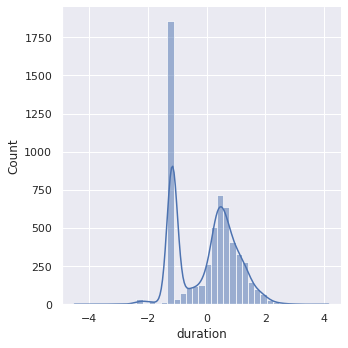

In [316]:
sns.displot(x=data['duration'], kde=True);

#### country

(547,)


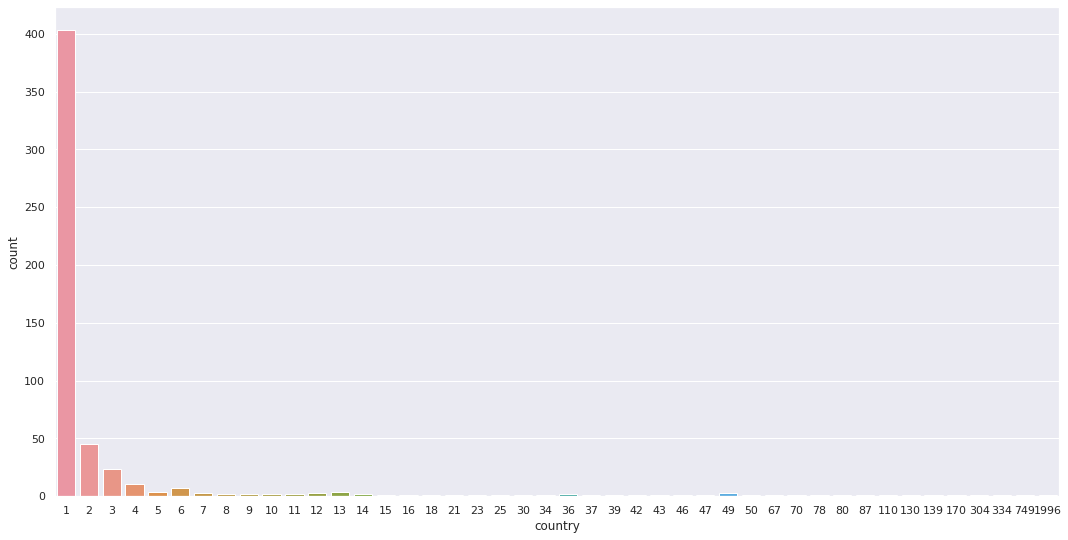

In [317]:
print(data['country'].value_counts().shape)
sns.countplot(x=data['country'].value_counts());
# for the first cycle I will just crate dummies with frequency > 5
# next cycle, it'll be cleaned and dimentionality reduction

In [363]:
df_dum = pd.get_dummies(data['country'])
df_dum_red = pd.DataFrame()
for col in df_dum:
    if df_dum[col].sum() > 5:
        df_dum_red[col] = df_dum[col]

data = pd.concat([data, df_dum_red], axis=1)

# removing old columns
dat = data.drop(['country'], axis=1)

#### texts columns

In [322]:
# title
# split with ':'  and put in other column
data['title_a'] = data['title'].apply(lambda x: x.split(':')[0])

# director
# split names with coma ','
data['director_a'] = data['director'].apply(lambda x: x.split(',')[0])

# cast
# split names with coma ',' getting the first cast
data['cast_a'] = data['director'].apply(lambda x: x.split(',')[0])

# listed in
# split names with coma ',' getting the first listed in
data['listed_in_a'] = data['director'].apply(lambda x: x.split(',')[0])

In [365]:
data.shape

(5903, 74)

In [366]:
data = data.drop([
    'title', 
    'director', 
    'cast', 
    'listed_in', 
    'description'
    ], axis=1)

In [367]:
# tranforming title_a in one hot encode
title_dum = pd.get_dummies(data['title_a'], prefix='title')
df_dum = pd.DataFrame()
for col in title_dum:
    if title_dum[col].sum() >=3:
        df_dum[col] = title_dum[col]
data = pd.concat([data, df_dum], axis=1)
data = data.drop(['title_a'], axis=1)

In [110]:
# renaming the columns removing gaps
col_list = list()
for col in data.columns.to_list():
    col_list.append(col.replace(' ', '_').replace(',', ''))

data.columns = col_list

## 5.0 - Modeling 

Preparing data

In [407]:
# Loading splitted files on silver layer
dataset = dict()
dataset['df_train'] = pd.read_parquet('../dataset/silver/netflix_train.parquet')
dataset['df_valid'] = pd.read_parquet('../dataset/silver/netflix_valid.parquet')
dataset['df_test'] = pd.read_parquet('../dataset/silver/netflix_test.parquet')

In [408]:
# ETL process to prepare data to modeling
for df_name in dataset.keys():
    df = data_cleaning(dataset[df_name])
    df = feature_eng(df)
    dataset[df_name] = data_transformation(df)

In [409]:
# shaping data as a train data shape to valid and test
df_train, df_valid, df_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for col in dataset['df_train'].columns:
    try:
        df_train[col] = dataset['df_train'][col]
    except:
        df_train[col] = 0
    try:
        df_valid[col] = dataset['df_valid'][col]
    except:
        df_valid[col] = 0
    try:
        df_test[col] = dataset['df_test'][col]
    except:
        df_test[col] = 0


df_train.shape, df_valid.shape, df_test.shape

((4715, 62), (600, 62), (588, 62))

In [410]:
# splitting data
x_train, y_train = df_train.drop('rating', axis=1), df_train['rating']
x_valid, y_valid = df_valid.drop('rating', axis=1), df_valid['rating']
x_test, y_test = df_test.drop('rating', axis=1), df_test['rating']

# analizin shape
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((4715, 61), (4715,), (600, 61), (600,), (588, 61), (588,))

### 5.1 - Baseline

### 5.2 - Models

In [411]:
# models to use on training data

models = {'Linear Regression':linear_model.LinearRegression(),
    'Lasso': linear_model.Lasso(random_state=1),
    'Ridge': linear_model.BayesianRidge(),
    'SVM': svm.SVR(),
    'Decision Tree Regressor': tree.DecisionTreeRegressor(random_state=1),
    'KNN': neighbors.KNeighborsRegressor(5),
    'Random Forest Regressor': RandomForestRegressor(random_state=1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=1),
    'Cat Boost': CatBoostRegressor(verbose=False, random_seed=1)
}

In [412]:
# dict to store the results of validation and test
results_valid = dict()
results_test = dict()
results_tvt = dict()

for im in models:
    # training model
    model = models[im]
    model = model.fit(x_train, y_train)
    predictions = model.predict(x_valid)

    # validation model trained
    results_valid[im] = round(mean_absolute_error(y_valid, predictions), 2)
    
    # test model trained
    predictions = model.predict(x_test)
    results_test[im] = round(mean_absolute_error(y_test, predictions), 2)

    # training with data train and valid together to test validation
    x_train_valid = pd.concat([x_train, x_valid], axis=0)
    y_train_valid = pd.concat([y_train, y_valid], axis=0)
    # retraining model
    model = models[im]
    model.fit(x_train_valid, y_train_valid)
    model.predict(x_test)
    # store the results
    results_tvt[im] = round(mean_absolute_error(y_test, predictions), 2)


### 5.3 - Model Validation

In [413]:
# creating dataframe with results for validation and test
validation = pd.DataFrame(results_valid.items(), columns=['Model', 'MAE']).sort_values(by="MAE")
test = pd.DataFrame(results_test.items(), columns=['Model', 'MAE']).sort_values(by="MAE")
tvt_test = pd.DataFrame(results_tvt.items(), columns=['Model', 'MAE']).sort_values(by="MAE")

In [414]:
# with only training data used to training
validation

,Model,MAE
7,Gradient Boosting,8.21
8,Cat Boost,8.30
2,Ridge,8.51
0,Linear Regression,8.52
6,Random Forest Regressor,8.69
1,Lasso,8.79
3,SVM,9.27
5,KNN,9.66
4,Decision Tree Regressor,11.48


In [415]:
# with only training data used to training
test

,Model,MAE
7,Gradient Boosting,8.32
8,Cat Boost,8.36
6,Random Forest Regressor,8.63
0,Linear Regression,8.66
2,Ridge,8.67
1,Lasso,9.24
5,KNN,9.40
3,SVM,9.78
4,Decision Tree Regressor,11.04


### 5.4 - Cross Validation

In [416]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

score_list = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_mean_squared_log_error',
    'explained_variance'
]
crv_n = [5, 10]
score_cv = dict()

regressor = GradientBoostingRegressor()
for score_item in score_list:
    for crv in crv_n:
        score_cv[score_item+'_'+str(crv)] = cross_val_score(
            regressor, x_train_valid, y_train_valid, cv=crv, scoring=score_item)


df_score = pd.DataFrame([score_cv]).T.reset_index().rename(columns={'index':'model', 0:'value'})
df_score['value'] = [np.mean(x) for x in df_score['value']]

In [417]:
df_score

,model,value
0,neg_mean_absolute_percentage_error_5,-0.138321
1,neg_mean_absolute_percentage_error_10,-0.138231
2,neg_mean_absolute_error_5,-8.290168
3,neg_mean_absolute_error_10,-8.290103
4,neg_mean_squared_error_5,-113.368344
5,neg_mean_squared_error_10,-113.341315
6,neg_mean_squared_log_error_5,-0.030512
7,neg_mean_squared_log_error_10,-0.030525
8,explained_variance_5,0.175439
9,explained_variance_10,0.175660


In [ ]:
# with cast

,model,value
0,neg_mean_absolute_percentage_error_5,-0.137227
1,neg_mean_absolute_percentage_error_10,-0.136955
2,neg_mean_absolute_error_5,-8.208922
3,neg_mean_absolute_error_10,-8.195459
4,neg_mean_squared_error_5,-111.554860
5,neg_mean_squared_error_10,-111.144917
6,neg_mean_squared_log_error_5,-0.030174
7,neg_mean_squared_log_error_10,-0.030034
8,explained_variance_5,0.188454
9,explained_variance_10,0.191271


In [ ]:
# with title

,model,value
0,neg_mean_absolute_percentage_error_5,-0.138187
1,neg_mean_absolute_percentage_error_10,-0.137993
2,neg_mean_absolute_error_5,-8.281179
3,neg_mean_absolute_error_10,-8.267877
4,neg_mean_squared_error_5,-112.934692
5,neg_mean_squared_error_10,-112.710474
6,neg_mean_squared_log_error_5,-0.030449
7,neg_mean_squared_log_error_10,-0.030390
8,r2_5,0.177767
9,r2_10,0.179140


In [248]:
y_true_pred = pd.concat([
    y_test, 
    pd.Series(predictions.astype('int'), index=y_test.index)],
    axis=1)

### 5.5 - Hyperparameters Fine Tuning

In [191]:
model = GradientBoostingRegressor(random_state=1)
model.fit(x_train_valid, y_train_valid)
predict = model.predict(x_test)

In [198]:
# parameters for tuning
alpha = [0.1, 0.3, 0.6, 0.9]
ccp_alpha = [0.0, 0.1, 0.3, 0.6]
learning_rate = [0.05, 0.1, 0.15, 0.2]
n_estimators=[50, 100, 150, 350, 500, 700, 1000]
subsample = [0.01, 0.02, 0.05, 0.07, 0.1, 0.3, 0.7]
max_depth = [2, 3, 5, 6, 8]
iterations = range(0, 7)
best_mae = 8.8

# randomly for tuning model
for d in max_depth:
    for l in learning_rate:
        for i in iterations:
            model = GradientBoostingRegressor(
                max_depth=d, 
                n_estimators=n_estimators[i],
                learning_rate=l,
                subsample=subsample[i], 
                verbose=False, 
                random_state=1
            )
            model = model.fit(x_train_valid, y_train_valid)
            predictions = model.predict(x_test)
            mae = mean_absolute_error(y_test, predictions)
            if mae < best_mae:
                best_mae = mae
                print(mae)

8.688265693878519
8.641792272590841
8.636554189144885
8.603274630692695
8.577386296514819


### 5.6 - Final Model

### 5.7 - Business Performance

## 6.0 - Next steps to improve the solution

* Create a solution to analyse the text "sentiment analysis" or others.
* better feature engineering with more calculus.
* Cross Validation and fine tunning.
* Identify the principal actor on all cast column
* Collect the data for imdb rating
* Collect the data for design production and effects
* Collect the data for the company that film the movie production
* Collect the data for user (click, views, watched, etc)